# MobileNetV2_CNN2
Pre-trained model

In [1]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten,Dropout, BatchNormalization, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow_addons.metrics import RSquare
from imgaug import augmenters as img_aug

import warnings
import random
import cv2
import pickle
import requests
import time

#from pushover import Client

warnings.filterwarnings('ignore')

/home/roscopikotrain/programs/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# Code to send notification to my phone

class PushoverCallback(tf.keras.callbacks.Callback):
    def __init__(self, client, title, sound, interval):
        super(PushoverCallback, self).__init__()
        self.client = client
        self.title = title
        self.sound = sound
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            message = f"Epoch {epoch + 1}: val_loss={logs['val_loss']:.4f}"
            self.client.send_message(message, title=self.title, sound=self.sound)

class TimeoutMonitor(tf.keras.callbacks.Callback):
    def __init__(self, client, title, sound, timeout=300):
        super(TimeoutMonitor, self).__init__()
        self.client = client
        self.title = title
        self.sound = sound
        self.timeout = timeout
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        if self.start_time is not None and (time.time() - self.start_time) > self.timeout:
            message = f"Training has not moved to the next epoch after {self.timeout} seconds"
            self.client.send_message(message, title=self.title, sound=self.sound)
            self.start_time = time.time()

pushover_api_token = 'a3vns7mdqta4mbp42eeqb1ymo6ear5'
pushover_user_key = 'u5c3e3f58nrkui6dpuk5njcpfigxie'
client = Client(pushover_user_key, api_token=pushover_api_token)

NameError: name 'Client' is not defined

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    #tf.config.experimental.set_virtual_device_configuration(
        #gpus[0],
        #[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) # Notice here
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [4]:
# Load csv file 
df = pd.read_csv('../datasets/PiCar/training_norm.csv', index_col=False)
df.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [5]:
df.shape

(13793, 3)

In [6]:
#df = df.drop('image_id', axis=1)
#df.head()

In [7]:
df['angle'].value_counts()

0.7500    2123
0.5000    2046
0.6875    2007
0.6250    1963
0.5625    1609
0.4375    1467
0.8125    1147
0.3750     428
0.8750     301
0.3125     213
0.2500     104
0.1250      99
0.1875      98
0.9375      65
0.0000      60
1.0000      35
0.0625      28
Name: angle, dtype: int64

In [8]:
a = df['image_id'].tolist()
b = [x for x in range(a[0], a[-1] + 1)]
missing_vals = list(set(a) ^ set(b))
print('Missing data:', missing_vals)

Missing data: [3141, 3999, 4895, 8285, 10171]


In [9]:
images_dir = '../datasets/PiCar/train/training_data'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/10171.png']

image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\10171.png']

images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,13793
unique,13793
top,../datasets/PiCar/train/training_data/10567.png
freq,1


In [10]:
df_all = pd.concat([df, images], axis=1)
df_all = df_all.drop('image_id', axis=1)
df_all.tail()

,angle,speed,images
13788,0.6250,1.0,../datasets/PiCar/train/training_data/13794.png
13789,0.4375,1.0,../datasets/PiCar/train/training_data/13795.png
13790,0.5625,0.0,../datasets/PiCar/train/training_data/13796.png
13791,0.6250,0.0,../datasets/PiCar/train/training_data/13797.png
13792,0.6875,1.0,../datasets/PiCar/train/training_data/13798.png


In [11]:
df_all.shape

(13793, 3)

In [12]:
#le = LabelEncoder()
#df_all['angle']= le.fit_transform(df_all['angle'])
#df_all.head()

image_path: ../datasets/PiCar/train/training_data/11.png
steering_Angle: 0.6875
Speed: 0.0


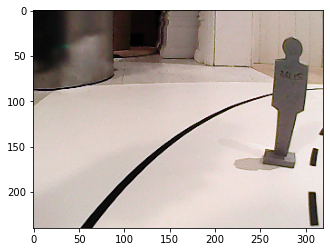

In [13]:
image_paths = df_all['images'].tolist()
steering_angles = df_all['angle'].tolist()
speed = df_all['speed'].tolist()


image_index = 10
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index]) 
print("steering_Angle:", steering_angles[image_index]) 
print("Speed:", speed[image_index]) 


(240, 320, 3)


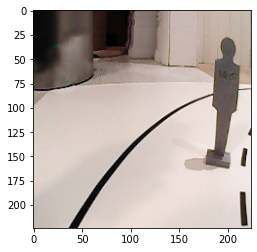

In [14]:
test_image = cv2.imread(df_all['images'][10])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
print(test_image.shape)
test_image = cv2.resize(test_image, (224,224))
plt.imshow(test_image)
plt.show()

In [15]:
X_train, X_valid = train_test_split( df_all, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 11034
Validation data: 2759


In [46]:
from tensorflow.keras.applications import MobileNetV2

class MobileNetV2_CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.mn = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    self.batch1 = BatchNormalization()
    self.conv1 = Conv2D(64, 3, activation='relu')# stride removing

    self.flatten = Flatten()
    self.drop1 = Dropout(0.25)
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(64, activation='relu')
    self.d3 = Dense(32, activation='relu')
    #self.drop2 = Dropout(0.25)
    self.d4 = Dense(16, activation='relu')

    self.Y1 = Dense(1, activation='relu')    
    self.Y2 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.mn(x)
    x = self.batch1(x)
    x = self.conv1(x)

    x = self.flatten(x)
    x = self.drop1(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    #x = self.drop2(x)
    x = self.d4(x)

    y1 = self.Y1(x)
    y2 = self.Y2(x)
    
    return y1,y2

In [47]:
model = MobileNetV2_CNN()
model.build((1,224, 224, 3))
model.summary()

Model: "mobile_net_v2_cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 batch_normalization_1 (Batc  multiple                 5120      
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           multiple                  737344    
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_6 (Dense)             multiple          

In [20]:
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.2))  # zoom from 100% (no zoom) to 120%
    image = zoom.augment_image(image)
    return image

def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 3)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
    return image

def random_augment(image):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    return image

In [21]:
def random_flip(image):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        image = cv2.flip(image,1)
    return image, is_flip

In [22]:
def custom_generator(df, batch_size, target_size, is_training):
    while True:
        # Shuffle the data
        df = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(df), batch_size):
            batch = df[i:i+batch_size]
            # Load images and labels
            images = []
            angles = []
            speeds = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                angle = row['angle']
                speed = row['speed']

                if is_training:
                    img = random_augment(img)
                    img, is_flip = random_flip(img)
                    if is_flip:
                        angle = 1 - angle

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)

                images.append(img)
                angles.append(angle)
                speeds.append(speed)

            # Normalize images
            images = np.array(images) / 255.0
            # Convert labels to arrays
            angles = np.array(angles)
            speeds = np.array(speeds)
            yield images, {'output_1': angles, 'output_2': speeds}

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [48]:
tf.keras.backend.clear_session()

# Early stop added
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#pushover_callback = PushoverCallback(client=client, title='Model Training Update', sound='cashregister', interval=1)
#timeout_callback = TimeoutMonitor(client=client, title='Training Stuck!!!!!!!!', sound='falling')

train_gen = custom_generator(X_train, batch_size=32 ,target_size=(224, 224), is_training= True)
val_gen = custom_generator(X_valid, batch_size=32, target_size=(224, 224), is_training= False)

model = MobileNetV2_CNN()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss={
        "output_1" : tf.keras.losses.MeanSquaredError(),
        "output_2" : tf.keras.losses.BinaryCrossentropy(from_logits=False)},
        metrics={"output_1": 'mse', "output_2": 'accuracy'})


history = model.fit(train_gen,
                    steps_per_epoch=len(X_train) // 32,
                    validation_data=val_gen,
                    validation_steps=len(X_valid) // 32,
                    callbacks=[callback],
                    epochs=150)

model.save('model/MobileNetV2_CNN',save_format='tf')

history_path = os.path.join('history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/150
344/344 [==============================] - 597s 2s/step - loss: 0.2896 - output_1_loss: 0.0800 - output_2_loss: 0.2097 - output_1_mse: 0.0800 - output_2_accuracy: 0.9088 - val_loss: 0.2588 - val_output_1_loss: 0.0268 - val_output_2_loss: 0.2320 - val_output_1_mse: 0.0268 - val_output_2_accuracy: 0.9317
Epoch 2/150
344/344 [==============================] - 576s 2s/step - loss: 0.0929 - output_1_loss: 0.0275 - output_2_loss: 0.0654 - output_1_mse: 0.0275 - output_2_accuracy: 0.9754 - val_loss: 0.0947 - val_output_1_loss: 0.0181 - val_output_2_loss: 0.0766 - val_output_1_mse: 0.0181 - val_output_2_accuracy: 0.9749
Epoch 3/150
344/344 [==============================] - 572s 2s/step - loss: 0.0691 - output_1_loss: 0.0202 - output_2_loss: 0.0489 - output_1_mse: 0.0202 - output_2_accuracy: 0.9838 - val_loss: 0.0861 - val_output_1_loss: 0.0194 - val_output_2_loss: 0.0667 - val_output_1_mse: 0.0194 - val_output_2_accuracy: 0.9844
Epoch 4/150
344/344 [==============================]

INFO:tensorflow:Assets written to: model/MobileNetV2_CNN/assets


INFO:tensorflow:Assets written to: model/MobileNetV2_CNN/assets


In [26]:
history_path = os.path.join('history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

def plots(history):
    # summarize history for accuracy
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(10,6))
    
    ax1.set_title('Angle Loss')
    ax1.plot(history['output_1_loss'])
    ax1.plot(history['val_output_1_mse'])
    ax1.set_yscale('log')
    ax1.legend(['train', 'test'], loc='lower right')
    
    ax2.set_title('Speed Accuracy')
    ax2.plot(history['output_2_accuracy'])
    ax2.plot(history['val_output_2_accuracy'])
    ax2.set_yscale('log')
    ax2.legend(['train', 'test'], loc='lower right')
    
    # summarize history for loss
    ax3.set_title('Angle MSE loss')  
    ax3.plot(history['output_1_loss'])
    ax3.plot(history['val_output_1_loss'])
    ax3.set_yscale('log')
    ax3.legend(['train', 'test'], loc='upper right')
   
    ax4.set_title('Speed loss')
    ax4.plot(history['output_2_loss'])
    ax4.plot(history['val_output_2_loss'])
    ax4.set_yscale('log')
    ax4.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

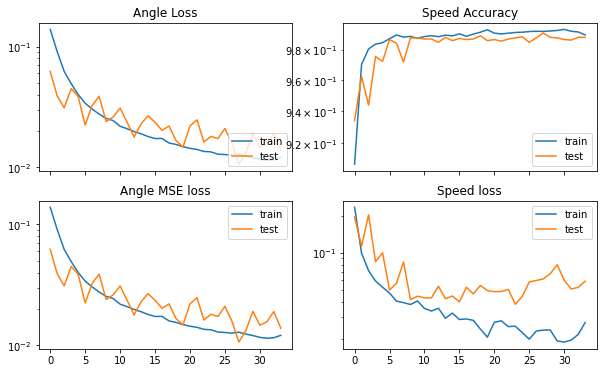

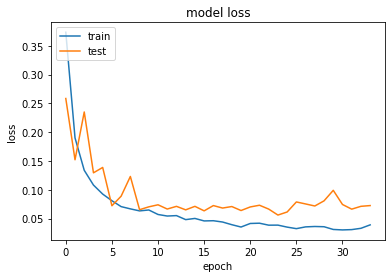

In [27]:
plots(history)

# Evaluation using validation set

In [28]:
def validation_generator(df, batch_size, target_size):
    while True:

        for i in range(0, len(df), batch_size):
            batch = df
            # Load images and labels
            images = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                images.append(img)

            images = np.array(images) / 255.0

            yield images

In [33]:
from keras.models import load_model
model = load_model('model/MobileNetV2_CNN')
valgen = next(validation_generator(X_valid, batch_size=2759, target_size=(224, 224)))
predict = model.predict(valgen)
print(predict)

87/87 [==============================] - 24s 267ms/step
(array([[0.6811256 ],
       [0.5201532 ],
       [0.65855706],
       ...,
       [0.59915847],
       [0.45168746],
       [0.47896993]], dtype=float32), array([[9.9995607e-01],
       [9.9999410e-01],
       [9.9998587e-01],
       ...,
       [1.2427170e-08],
       [1.4360480e-05],
       [1.0860623e-05]], dtype=float32))


In [34]:
angles = pd.DataFrame(predict[0], columns=['angle'])
speed = pd.DataFrame(predict[1], columns=['speed'])
pred_df = pd.concat([angles, speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df.head()

,image_id,angle,speed
0,1,0.681126,0.999956
1,2,0.520153,0.999994
2,3,0.658557,0.999986
3,4,0.565694,0.999984
4,5,0.412407,0.004299


In [35]:
pred_df.shape

(2759, 3)

### MSE before round

In [36]:
mse = tf.keras.losses.MeanSquaredError()
angle_mse = mse(X_valid['angle'], pred_df['angle']).numpy()
speed_mse = mse(X_valid['speed'], pred_df['speed']).numpy()
print(f'mse angle: {angle_mse}\nmse speed: {speed_mse}')

mse angle: 0.013845913112163544
mse speed: 0.009303800761699677


In [37]:
total_mse = angle_mse + speed_mse
print(f'Total mse: {total_mse}')

Total mse: 0.02314971387386322


In [38]:
pred_df_rnd = pred_df.round({'angle': 4,'speed': 0})
pred_df_rnd.head()

,image_id,angle,speed
0,1,0.6811,1.0
1,2,0.5202,1.0
2,3,0.6586,1.0
3,4,0.5657,1.0
4,5,0.4124,0.0


In [39]:
angle_mse = mse(X_valid['angle'], pred_df_rnd['angle']).numpy()
speed_mse = mse(X_valid['speed'], pred_df_rnd['speed']).numpy()
print(f'mse angle: {angle_mse}\nmse speed: {speed_mse}')

mse angle: 0.013845792971551418
mse speed: 0.011664978228509426


In [40]:
total_mse = angle_mse + speed_mse
print(f'Total mse: {total_mse}')

Total mse: 0.025510771200060844


In [41]:
pred_df_rnd['speed'] = pd.to_numeric(pred_df_rnd['speed'],downcast="integer" )
pred_df_rnd.head()

,image_id,angle,speed
0,1,0.6811,1
1,2,0.5202,1
2,3,0.6586,1
3,4,0.5657,1
4,5,0.4124,0


In [42]:
X_valid['speed']=X_valid['speed'].astype("int")
X_valid.head()

,angle,speed,images
11375,0.6250,1,../datasets/PiCar/train/training_data/11381.png
12936,0.4375,1,../datasets/PiCar/train/training_data/12942.png
11020,0.6875,1,../datasets/PiCar/train/training_data/11026.png
12766,0.5625,1,../datasets/PiCar/train/training_data/12772.png
6120,0.5000,0,../datasets/PiCar/train/training_data/6124.png


In [43]:
cm = confusion_matrix(X_valid['speed'], pred_df_rnd['speed'])

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       658
           1       0.99      0.99      0.99      2101

    accuracy                           0.99      2759
   macro avg       0.98      0.98      0.98      2759
weighted avg       0.99      0.99      0.99      2759



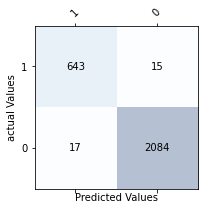

In [44]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
classes=["1", "0"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('actual Values',);
print(classification_report(X_valid['speed'], pred_df_rnd['speed']))

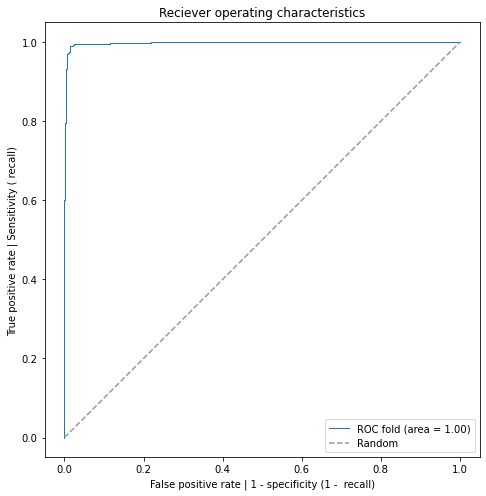

In [45]:
# Plot the rciever opertaing characteristic curve (ROC)
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,8))
#probas_ = model.predict(X_valid['speed'])
fpr, tpr, thresholds = roc_curve(X_valid['speed'], pred_df['speed'])
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr, lw=1, label='ROC fold (area = %0.2f)' %(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate | 1 - specificity (1 -  recall)')
plt.ylabel('True positive rate | Sensitivity ( recall)')
plt.title('Reciever operating characteristics')
plt.legend(loc="lower right")
plt.axes().set_aspect(1);

# Testing

In [65]:
images_dir = '../datasets/PiCar/test'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)

images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,1020
unique,1020
top,../datasets/PiCar/test/1.png
freq,1


In [66]:
def test_generator(df, batch_size, target_size):
    while True:

        for i in range(0, len(df), batch_size):
            batch = df
            # Load images and labels
            images = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                images.append(img)

            images = np.array(images) / 255.0

            yield images

In [67]:
from keras.models import load_model
model = load_model('model/VGG16_CNN')
testgen = next(test_generator(images, batch_size=1020, target_size=(224, 224)))
predict = model.predict(testgen)
print(predict)

32/32 [==============================] - 2s 59ms/step
(array([[0.4701935 ],
       [0.69952273],
       [0.16464736],
       ...,
       [0.35066307],
       [0.25652134],
       [0.08131767]], dtype=float32), array([[4.8308780e-06],
       [9.9996638e-01],
       [9.9909163e-01],
       ...,
       [9.9998760e-01],
       [9.9987006e-01],
       [9.9907815e-01]], dtype=float32))


In [68]:
angles = pd.DataFrame(predict[0], columns=['Angle'])
speed = pd.DataFrame(predict[1], columns=['speed'])
pred_df = pd.concat([angles, speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df.head()

,image_id,Angle,speed
0,1,0.470194,0.000005
1,2,0.699523,0.999966
2,3,0.164647,0.999092
3,4,0.089324,0.998976
4,5,0.101690,0.999283


In [69]:
pred_df = pred_df.round({'Angle': 4})
pred_df.head()

,image_id,Angle,speed
0,1,0.4702,0.000005
1,2,0.6995,0.999966
2,3,0.1646,0.999092
3,4,0.0893,0.998976
4,5,0.1017,0.999283


In [70]:
pred_df.to_csv('Tow_mat_VGG16.csv', index=False)

In [35]:
test = next(custom_generator(X_valid, batch_size=10, target_size=(240, 120), is_training=False))

In [36]:
predict_test = model.predict(test[0])

1/1 [==============================] - 0s 18ms/step


In [37]:
print(predict_test[0])

[[0.5511235 ]
 [0.7568309 ]
 [0.7777829 ]
 [0.72114545]
 [0.4993554 ]
 [0.54714364]
 [0.47722927]
 [0.5665439 ]
 [0.6199493 ]
 [0.7158552 ]]


In [38]:
print(test[1])

{'output_1': array([0.625 , 0.75  , 0.6875, 0.6875, 0.5   , 0.5   , 0.5   , 0.5625,
       0.625 , 0.6875]), 'output_2': array([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.])}
